In [33]:
import numpy as np
import pandas as pd
import math
import re
from nltk.corpus import stopwords
import seaborn as sns
import unidecode
from sklearn.utils import resample
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns 
warnings.filterwarnings('ignore')

In [34]:
df_2022 = pd.read_csv('../data/tweet_data_2022.csv')
df_2023 = pd.read_csv('../data/tweet_data_2023.csv')

### Three types of Sampling Strategies
- Committee-based Strategies
    -  Build several models and use the models’ prediction to determine the most informative data. The data is considered as most informative if there is maximum disagreement in predictions from the models. The disagreement can be measured by entropy or KL-Divergence
        - Query by Committee (QBC)
        - Entropy-based Query by Bagging (EQB)
        - Adaptive Maximum Disagreement (AMD)


- Large margin-based Strategies
    - Specifically for margin-based classifiers such as SVM. The distance to the separating hyperplane can be viewed as a good metric to measure the model’s confidence or certainty on unlabeled data samples. In SVM, the support vectors which define the decision boundary would be the most informative data samples.
        - Margin Sampling (MS)
        - Multiclass Level Uncertainty (MCLU)
        - Margin Sampling-closest Support Vectors (MS-cSV)
        
- Posterior probability-based Strategies
    - Based on the estimation of class membership probabilities. The posterior probability distribution is used to determine whether the unlabeled data sample should be queried for label or not. This strategy can be used with any type of model which has the ability to predict output probabilities for class membership. The posterior probability distribution gives an idea about the model’s confidence and certainty in the assignment of a particular class to the data sample.
        - Least Confidence (LC)
        - Best-versus-Second-Best (BvSB) or Smallest Margin
        - Entropy

- **Yunyi** will explore **Query by Committee (QBC)** and **Entropy-based Query by Bagging (EQB)**


- **Tony** will explore Posterior probability-based Startegies including **least confidence** and **Entropy**

From the previous quarter, the best model for relevance prediction is **Naive Bayes** and the best model for sentiment prediction is **Random Forest**. Because neither Naive Bayes nor Random Forest belongs to margin-based models, we will not explore large margin-based startegies in the project. 

### Active Learning Pipeline Procedures

**1. Balance and partition the dataset**
- Shuffle the dataset and separate the data based on the label (Group 1 vs. Group 2 or 3)
- For each group of data:
    - Seed: Used for training the model, 80% of the dataset
    - Unlabeled: Used for active learning, 10% of the dataset
    - Test: Used for testing the changes of model result before and after the active learning, 10% of the dataset
- Combine the groups of data

**2. Train the model using Seed data and cross-validation**
- Train the Bernoulli Naive Bayes Model using the Seed data
- Apply cross-validation to find the most consistant model parameters

**3. Choose unlabeled instances**
- Using Pool-based sampling, choose the round of iterations and the number of instances to add to the training set
- For each iteration, 
    - select X instances from the unlabeled data using the sampling strategies
    - add the instances to the training set
    
**4. Stopping criteria**
- \# of instances queried
- \# of iterations of steps 2 and 3
- After the performance doesn't imporve significantly

**5. Compare the model performances on Test set**
- Report the accuracy of the model that uses only Seed data as the training set
- Report the accuracy of the model after using active learning
- Report the accuracy of the model with random sampled data from the unlabeled pool

### Data Preprocessing

In [3]:
def standardize_bucket(bucket):
    if ((bucket == '1.0') | (bucket == '1')):
        return '1'
    elif ((bucket == '2') | (bucket == '3') | (bucket == '2.0') | (bucket == '3.0')):
        return '2 or 3'
    else:
        return bucket

In [4]:
def clean_text(text):
    if type(text) == np.float:
        return ""
    temp = text.lower() # to lower case
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # remove @s
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # remove hashtags
    temp = re.sub(r'http\S+', '', temp) # remove links
    temp = re.sub(r"www.\S+", "", temp) # remove links
    temp = re.sub(r'\n|[^a-zA-Z]', ' ', temp) # remove punctuation
    temp = temp.replace("\n", " ").split()
    temp = [w for w in temp if not w in stopwords_] # remove stopwords
    temp = [w for w in temp if not w.isdigit()] # remove numbers
    temp = [unidecode.unidecode(w) for w in temp] # turn non-enlish letters to english letters
    temp = " ".join(word for word in temp)
    return temp

In [5]:
original_stopwords = stopwords.words('english')
additional_stopwords = ['none']
original_stopwords.extend(additional_stopwords)
stopwords_ = set(original_stopwords)

#Selects only the tweets about China
df = df_2022[df_2022['country']=='China']
df = df[['text', 'id', 'Bucket', 'SentimentScore']]
#Shuffle the data
df = df.sample(frac=1, replace=False, random_state=1) 
df.reset_index(drop=True, inplace=True)
#Standardized the bucket label
df['Bucket'] = df['Bucket'].apply(standardize_bucket)
#Remove tweets that are in both buckets
df_bucket_count = pd.DataFrame(df.groupby('id')['Bucket'].nunique())
df_bucket_count.reset_index(inplace=True)
df_bucket_count.columns = ['tweet_id', 'bucket_num']
df = df.merge(df_bucket_count, left_on='id', right_on='tweet_id')
df = df[df['bucket_num'] == 1]
#Remove tweets without a bucket (null)
df = df[(df['Bucket'] == '1') | (df['Bucket'] == '2 or 3')]
#Remove duplicates
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
df = df[['text', 'Bucket']]
df["text_cleaned"] = [clean_text(t) for t in df["text"]]

### 1. Balance and Partition the dataset (Group 1 vs. Group 2 or 3; Seed, Unlabeled, Test)

In [6]:
df_1 = df[df.Bucket=='1']
df_2_3 = df[df.Bucket=='2 or 3']
sample_size = min(df[df.Bucket=='1'].shape[0], df[df.Bucket=='2 or 3'].shape[0])

In [7]:
def partition_data(df):
    #partiton
    df_rows = df.shape[0]
    seed_num = math.floor(df_rows * 0.8)
    seed = df[:seed_num]
    unlabelled_num = seed_num + (math.floor(df_rows * 0.1))
    unlabelled = df[seed_num:unlabelled_num]
    test = df[unlabelled_num:]
    return seed, unlabelled, test

In [8]:
seed_1, unlabeled_1, test_1 = partition_data(df_1)
seed_2_3, unlabeled_2_3, test_2_3 = partition_data(df_2_3)
seed = pd.concat([seed_1, seed_2_3])
unlabeled = pd.concat([unlabeled_1, unlabeled_2_3])
test = pd.concat([test_1, test_2_3])
# print(seed.shape)
# print(unlabeled.shape)
# print(test.shape)

In [9]:
seed_1 = seed[seed.Bucket=='1']
seed_2_3 = seed[seed.Bucket=='2 or 3']
sample_size = min(seed_1.shape[0], seed_2_3.shape[0])
seed_1_b = resample(seed_1, replace=False, n_samples=sample_size, random_state=123)
seed_2_3_b = resample(seed_2_3, replace=False, n_samples=sample_size, random_state=123)
seed = pd.concat([seed_1_b, seed_2_3_b])

In [10]:
seed.Bucket.value_counts()

1         1649
2 or 3    1649
Name: Bucket, dtype: int64

In [11]:
initial_seed = seed.copy()
initial_unlabeled = unlabeled.copy()

### 2. Train the model using Seed data and cross-validation

In [12]:
def train_model(seed):
    random_state_value = 2
    round_number = 4
    categories = ['Bucket']
    train, test = train_test_split(seed, random_state=42, test_size=0.2, shuffle=True)
    X_train, X_test, Y_train, Y_test = train[['text_cleaned']], test[['text_cleaned']], train[['Bucket']], test[['Bucket']]
#     print("X_train has {} rows.".format(X_train.shape[0]))
#     print("X_test has {} rows.".format(X_test.shape[0]))
#     print("Y_train has {} rows.".format(Y_train.shape[0]))
#     print("Y_test has {} rows.".format(Y_test.shape[0]))
    
    #Wrap in ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("tf", CountVectorizer(stop_words=stopwords_), 'text_cleaned'),
            ("tfidf", TfidfVectorizer(stop_words=stopwords_), 'text_cleaned')]
    )
    
    #Define the model
    model = BernoulliNB(fit_prior=True, class_prior=None)
    model_name = 'Bernoulli Naive Bayes'
    
    #Build the pipeline
    pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('clf', OneVsRestClassifier(model, n_jobs=1)),
            ])
    
    #Train the model
    pipeline.fit(X_train, Y_train)

    # compute the testing accuracy
    prediction = pipeline.predict(pd.DataFrame(X_test))
#     print('The model name is ' + model_name + '.')
#     print('Test accuracy is {}'.format(round(accuracy_score(Y_test, prediction), round_number)))
    
    # compute the f1 score
#     f1 = round(f1_score(np.array(Y_test), prediction, pos_label='1'), round_number)
#     print('F1 score is {}'.format(f1))
    # compute the precision score
#     precision = round(precision_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
#     print('Precision score is {}'.format(precision))
    # compute the precision score
#     recall = round(recall_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
#     print('Recall score is {}'.format(recall))
#     plot_confusion_matrix(pipeline, X_test, Y_test)
#     plt.show()
#     plot_confusion_matrix(pipeline, X_test, Y_test, normalize='true')
#     plt.show()
    
    #Cross Validation
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    cross_val_score_train = cross_val_score(pipeline, X_train, Y_train, cv=cv)
#     print("Cross Validation on the training set")
#     print(round(np.mean(cross_val_score_train), 3))
    
    return pipeline, round(np.mean(cross_val_score_train), 3)

In [13]:
initial_pipeline, initial_score  = train_model(initial_seed)

## 3. Choose unlabeled instances

#### Least Confidence

- Select the unlabeled data samples for which the model is least confident in prediction or class assignment. 
- These data samples improve the model’s discriminative ability. 50%-50% > 90%-10%


In [14]:
def calc_entropy(x):
    p1, p2 = x[0], x[1]
    entropy = p1 * math.log2(1/p1) + p2 * math.log2(1/p2)
    return entropy

#Choose strategy
def choose_unlabeled(pipeline, unlabeled):
    unlabeled_x = unlabeled[['text_cleaned']]
    unlabeled_y = unlabeled[['Bucket']]
    prob = pipeline.predict_proba(unlabeled_x)
    unlabeled['prob'] = list(prob)
    unlabeled['lc'] = np.abs(np.diff(prob)).flatten() #least confidence
    unlabeled['entropy'] = unlabeled['prob'].apply(calc_entropy) #entropy
    unlabeled.sort_values(by=['entropy'], ascending=False, inplace=True)

In [15]:
# sns.distplot(unlabeled['lc'], hist=True, kde=True, 
#              bins=int(20), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

### 4. Stopping Criteria

1. Update the unlabeled data and the info_data
2. Add info_data to the training set
2. Retrain the model
3. Select the data with the most informative data again


## Active Learning Pipeline

In [16]:
#     ''' 
#     seed      - initial training data for the model
#     instances - number of instances to add to the seed data in one iteration
#     iteration - number of iteration for the active learning process
#     '''
    
def active_learning(seed, unlabeled, instances, iteration):
    for i in range(iteration):
#         print('--------------------------------')
#         print('Seed has {} rows'.format(seed.shape[0]))
        # Record model result
        pipeline, model_result = train_model(seed)
        choose_unlabeled(pipeline, unlabeled) #sort the unlabeled data based on informativeness level

        #Update the unlabeled data and the info_data
        info_data = unlabeled.iloc[:instances]
        unlabeled = unlabeled.iloc[instances:]

        # Add info_data to the training set
        seed = pd.concat([seed, info_data[['text', 'Bucket', 'text_cleaned']]])
#         print('--------------------------------')
    return pipeline, instances, iteration, model_result

In [17]:
# instances_lst = [2, 4, 6, 8, 10, 20, 30, 40]
# iteration_lst = [1, 2, 3, 4, 5]
# model_result_lst = []
# model_spec_lst = []

# for i in instances_lst:
#     for j in iteration_lst:
#         print('--------------------------------')
#         print('instance = {}'.format(i))
#         print('iteration = {}'.format(j))
#         pipeline, instances, iteration, model_result = active_learning(initial_seed, initial_unlabeled, i, j) 
#         model_spec_lst.append([instances, iteration])
#         model_result_lst.append(model_result)

--------------------------------
instance = 2
iteration = 1
--------------------------------
instance = 2
iteration = 2
--------------------------------
instance = 2
iteration = 3
--------------------------------
instance = 2
iteration = 4
--------------------------------
instance = 2
iteration = 5
--------------------------------
instance = 4
iteration = 1
--------------------------------
instance = 4
iteration = 2
--------------------------------
instance = 4
iteration = 3
--------------------------------
instance = 4
iteration = 4
--------------------------------
instance = 4
iteration = 5
--------------------------------
instance = 6
iteration = 1
--------------------------------
instance = 6
iteration = 2
--------------------------------
instance = 6
iteration = 3
--------------------------------
instance = 6
iteration = 4
--------------------------------
instance = 6
iteration = 5
--------------------------------
instance = 8
iteration = 1
--------------------------------
instanc

In [18]:
# x = np.array(model_spec_lst)[:, 0]
# y = np.array(model_spec_lst)[:, 1]
# z = np.array(model_result_lst)
# d = np.dstack([x,y,z])[0]
# model_df = pd.DataFrame(d, columns=['instances', 'iteration', 'model_score'])

<AxesSubplot:>

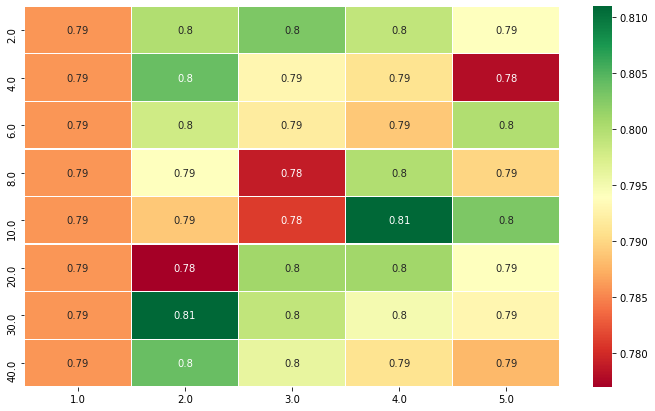

In [21]:
# ins_set = set(model_df['instances'])
# iter_set = set(model_df['iteration'])
# score = np.array(model_df['model_score']).reshape([len(instances_lst), len(iteration_lst)])
# idx_raw = list(ins_set)
# idx_raw.sort()
# idx = idx_raw
# # Defining columns for the dataframe
# cols = list(iter_set)
# heat_df = pd.DataFrame(score, columns = cols, index = idx)
# # Defining figure size for the output plot 
# fig, ax = plt.subplots(figsize = (12, 7))
# # Displaying dataframe as an heatmap 
# # with diverging colourmap as RdYlGn
# sns.heatmap(heat_df, cmap ='RdYlGn', linewidths = 0.30, annot = True)

## 5. Model Result Comparison

In [22]:
def test_model(pipeline, data):
    random_state_value = 2
    round_number = 4
    categories = ['Bucket']
    X_test, Y_test = data[['text_cleaned']], data[['Bucket']]
    print("X_test has {} rows.".format(X_test.shape[0]))
    print("Y_test has {} rows.".format(Y_test.shape[0]))

    # compute the testing accuracy
    prediction = pipeline.predict(pd.DataFrame(X_test))
    print('Test accuracy is {}'.format(round(accuracy_score(Y_test, prediction), round_number)))
    
    # compute the f1 score
    f1 = round(f1_score(np.array(Y_test), prediction, pos_label='1'), round_number)
    print('F1 score is {}'.format(f1))
    # compute the precision score
    precision = round(precision_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
    print('Precision score is {}'.format(precision))
    # compute the precision score
    recall = round(recall_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
    print('Recall score is {}'.format(recall))
    plot_confusion_matrix(pipeline, X_test, Y_test)
    plt.show()
    plot_confusion_matrix(pipeline, X_test, Y_test, normalize='true')
    plt.show()

### Model (Trained w/ seed) Performance

X_test has 1016 rows.
Y_test has 1016 rows.
Test accuracy is 0.7717
F1 score is 0.8398
Precision score is 0.9515
Recall score is 0.7515


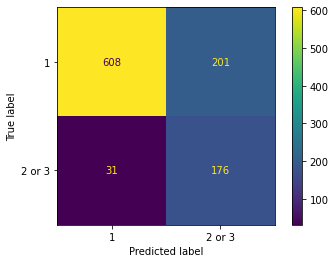

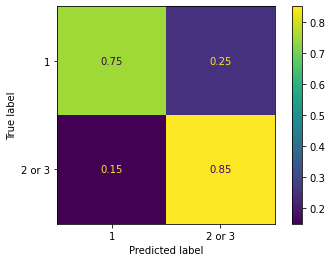

In [23]:
test_model(initial_pipeline, test)

### Model (Trained w/ seed + randomly sampled unlabeled) Performance

X_test has 1016 rows.
Y_test has 1016 rows.
Test accuracy is 0.7766
F1 score is 0.8438
Precision score is 0.9519
Recall score is 0.7577


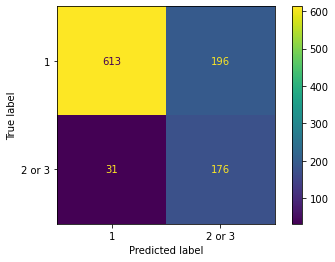

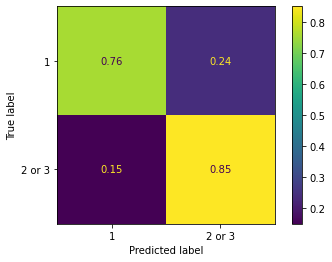

In [24]:
#Shuffle the data
sample_unlabeled = initial_unlabeled.sample(n=40, replace=False, random_state=1) 
# initial_unlabeled.reset_index(drop=True, inplace=True)
seed_and_sample_unlabeled_df = pd.concat([initial_seed, sample_unlabeled])
seed_and_sample_unlabeled_pipeline, seed_and_sample_unlabeled_score = train_model(seed_and_sample_unlabeled_df)
test_model(seed_and_sample_unlabeled_pipeline, test)

### Model (Trained w/ seed + active learning) Performance

X_test has 1016 rows.
Y_test has 1016 rows.
Test accuracy is 0.7736
F1 score is 0.8414
Precision score is 0.9516
Recall score is 0.754


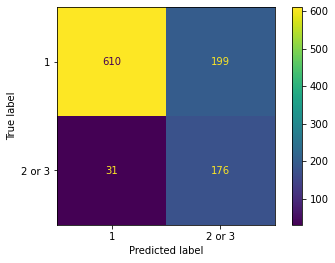

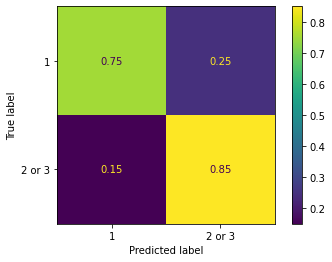

In [27]:
active_learning_pipeline, instances, iteration, model_result = active_learning(initial_seed, initial_unlabeled, 10, 4)
test_model(active_learning_pipeline, test)

#### Best-versus-Second-Best (BvSB)

- Find the two most probable classes (the classes having the highest and second-highest probabilities), then minimize the difference of probabilities between them.
- 0.8 - 0.1 = 0.7; 0.5 - 0.4 = 0.1; 0.7 > 0.1 so (0.5, 0.4 is more uncertain)


Since we only have two classes here, therefore, we will not explore Best-versus-Second-Best strategy

#### Entropy

- For classification with a large number of classes, above two posterior probability-based strategies do not fit to be optimal because they consider one or two most probable classes for sampling. The information lying in the remaining classes’ probability distribution is unused. To address this issue, the entropy measure is designed for sampling.
- Maximize the entropy will give us the data sample which the model is least certain about the class assignment.


**Binary Cross Entropy** is the negative average of the log of corrected predicted probabilities.

https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/